<a href="https://colab.research.google.com/github/Royer511/ML-Cartpole/blob/main/cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import numpy as np
import gym
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import math

In [12]:
# Create the CartPole environment
env = gym.make("CartPole-v1")

In [13]:
# @title
class CartPoleAgent:
    def __init__(self, buckets=(1, 1, 6, 12),
                 learning_rate=0.1, discount_factor=0.95,
                 exploration_rate=1.0, exploration_decay_rate=0.99):
        self.buckets = buckets
        self.q_table = defaultdict(lambda: np.zeros(env.action_space.n))
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay_rate = exploration_decay_rate
        self.rewards = []
        self.episode_lengths = []
        self.training_errors = []

    def discretize(self, state):
        upper_bounds = [env.observation_space.high[0], 0.5, env.observation_space.high[2], math.radians(50)]
        lower_bounds = [env.observation_space.low[0], -0.5, env.observation_space.low[2], -math.radians(50)]
        ratios = [(state[i] + abs(lower_bounds[i])) / (upper_bounds[i] - lower_bounds[i]) for i in range(len(state))]
        new_obs = [int(round((self.buckets[i] - 1) * ratios[i])) for i in range(len(state))]
        new_obs = [min(self.buckets[i] - 1, max(0, new_obs[i])) for i in range(len(state))]
        return tuple(new_obs)

    def get_action(self, state):
        if np.random.random() < self.exploration_rate:
            return env.action_space.sample()
        else:
            return np.argmax(self.q_table[state])

    def update_q_values(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        updated_value = reward + self.discount_factor * self.q_table[next_state][best_next_action]
        self.q_table[state][action] += self.learning_rate * (updated_value - self.q_table[state][action])

    def decay_exploration_rate(self):
        self.exploration_rate *= self.exploration_decay_rate


In [14]:
agent = CartPoleAgent()

n_episodes = 1000

for episode in tqdm(range(n_episodes)):
    current_state = agent.discretize(env.reset())
    done = False
    episode_reward = 0  # to accumulate rewards for this episode
    episode_length = 0  # to accumulate the length of this episode

    while not done:
        action = agent.get_action(current_state)
        next_state, reward, done, _ = env.step(action)
        episode_reward += reward
        episode_length += 1
        next_discrete_state = agent.discretize(next_state)

        # updating Q-values
        agent.update_q_values(current_state, action, reward, next_discrete_state)

        current_state = next_discrete_state

    agent.decay_exploration_rate()  # Ensure exploration rate decays over episodes

    agent.rewards.append(episode_reward)
    agent.episode_lengths.append(episode_length)

100%|██████████| 1000/1000 [00:03<00:00, 267.86it/s]


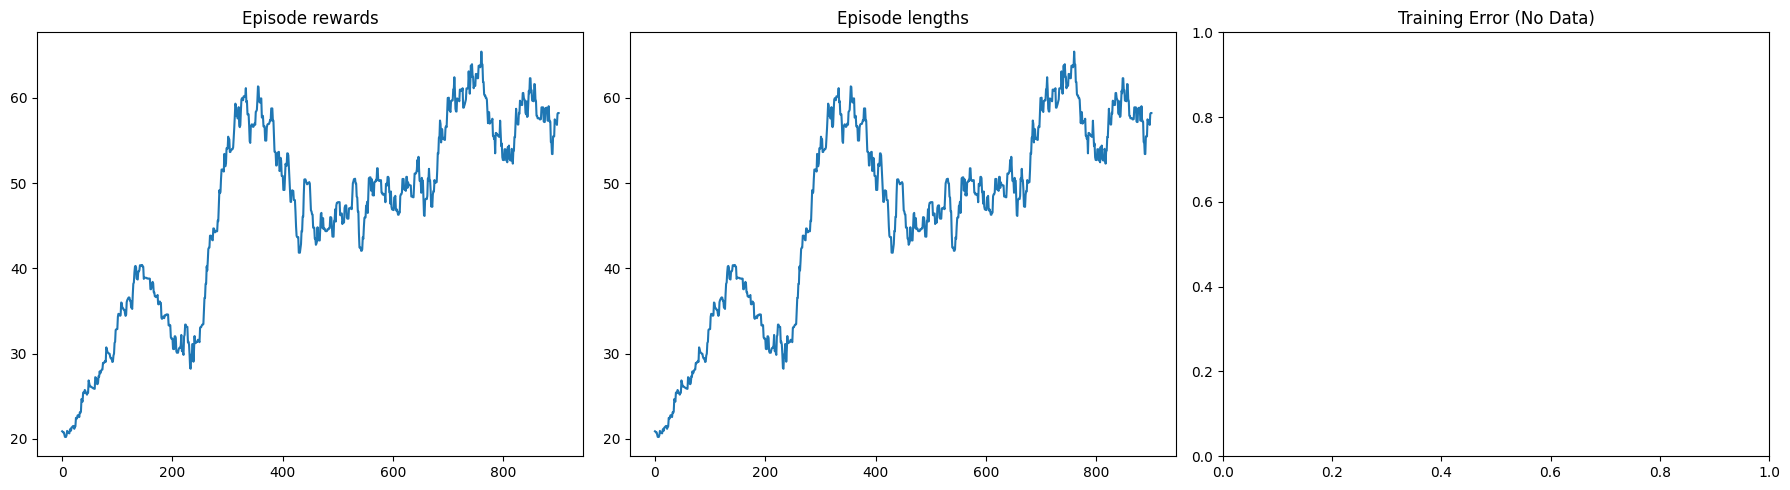

In [15]:
# Hyperparameters for plotting
rolling_length = 100  # We'll use a rolling average over 100 episodes to smooth the visualization

# Create the plots
fig, axs = plt.subplots(ncols=3, figsize=(18, 5))

# 1. Episode rewards
axs[0].set_title("Episode rewards")
reward_moving_average = (
    np.convolve(agent.rewards, np.ones(rolling_length), mode="valid")
    / rolling_length
)
axs[0].plot(reward_moving_average)

# 2. Episode lengths
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(agent.episode_lengths, np.ones(rolling_length), mode="valid")
    / rolling_length
)
axs[1].plot(length_moving_average)

# 3. Training Error
if len(agent.training_errors) > 0:
    axs[2].set_title("Training Error")
    training_error_moving_average = (
        np.convolve(agent.training_errors, np.ones(rolling_length), mode="valid")
        / rolling_length
    )
    axs[2].plot(training_error_moving_average)
else:
    axs[2].set_title("Training Error (No Data)")

# Show the plots
plt.tight_layout()
plt.show()


**Episode Rewards:** Ideally, you'd want the rewards to increase over time, indicating that the agent is learning to make better decisions.
**Episode Lengths:** This indicates how long each episode lasts. An increasing trend might suggest the agent is improving (depending on the task).